<a href="https://colab.research.google.com/github/Heinrikii/DesafioDIO-TreinentoRedesNeuraisTransferLearning/blob/main/DIO_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Abaixo carregando em um vetor as imagens

In [29]:
root = 'DataSet_cat_dog'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['DataSet_cat_dog/gatos', 'DataSet_cat_dog/.git', 'DataSet_cat_dog/.git/logs', 'DataSet_cat_dog/.git/logs/refs', 'DataSet_cat_dog/.git/logs/refs/heads', 'DataSet_cat_dog/.git/logs/refs/remotes', 'DataSet_cat_dog/.git/logs/refs/remotes/origin', 'DataSet_cat_dog/.git/refs', 'DataSet_cat_dog/.git/refs/tags', 'DataSet_cat_dog/.git/refs/heads', 'DataSet_cat_dog/.git/refs/remotes', 'DataSet_cat_dog/.git/refs/remotes/origin', 'DataSet_cat_dog/.git/objects', 'DataSet_cat_dog/.git/objects/info', 'DataSet_cat_dog/.git/objects/pack', 'DataSet_cat_dog/.git/info', 'DataSet_cat_dog/.git/branches', 'DataSet_cat_dog/.git/hooks', 'DataSet_cat_dog/cachorros']


Está função é útil para pré-processar os dados em uma imagem e um vetor de entrada

In [30]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carrega todas as imagens na pasta raiz

In [31]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomiza a ordem dos dados.

In [32]:
random.shuffle(data)

Cria divisão de treinamento/validação/teste (70%, 15%, 15%)

In [33]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Dados Separados por rótulos

In [34]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 18, 0, 0, 0, 0, 0, 0, 18, 18, 18, 18, 0, 18, 18, 18, 0, 18, 18, 0, 18, 0, 18, 0, 0, 0, 0, 18, 18, 18]


Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e .

In [35]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(30, 19)


Vamos fazer um resumo do que temos.

In [36]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 200 images from 19 categories
train / validation / test split: 140, 30, 30
training data shape:  (140, 224, 224, 3)
training labels shape:  (140, 19)


Se tudo funcionou corretamente, você deve ter carregado um monte de imagens e dividido elas em três conjuntos: train, val, e test. O formato dos dados de treinamento deve ser ( n, 224, 224, 3) onde né o tamanho do seu conjunto de treinamento, e os rótulos devem ser ( n, c) onde cé o número de classes (97 no caso de 101_ObjectCategories.

Observe que dividimos todos os dados em três subconjuntos — um conjunto de treinamento train, um conjunto de validação vale um conjunto de teste test. O motivo para isso é avaliar adequadamente a precisão do nosso classificador. Durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem overfitting ao conjunto de treinamento. O testconjunto é sempre mantido fora do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

Vamos dar uma olhada rápida em algumas imagens de exemplo do nosso conjunto de dados.

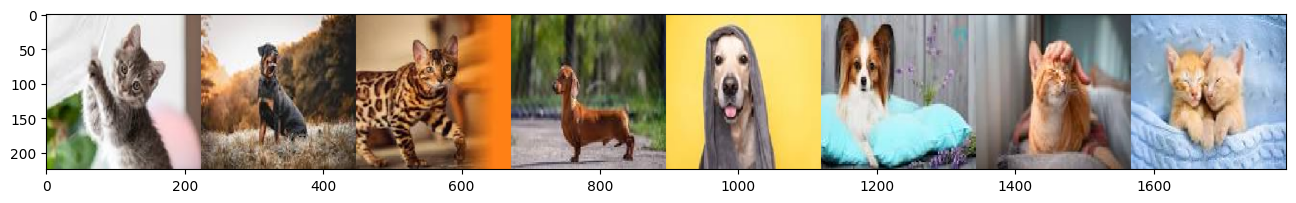

In [37]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Primeiro treinamento de uma rede neural do zero
Antes de fazer a transferência de aprendizado, vamos primeiro construir uma rede neural do zero para fazer a classificação em nosso conjunto de dados. Isso nos dará uma linha de base para comparar com nossa rede de transferência aprendida mais tarde.

A rede que construiremos contém 4 camadas convolucionais e de max-pooling alternadas, seguidas por um dropout após cada outro par conv/pooling. Após a última camada de pooling, anexaremos uma camada totalmente conectada com 256 neurônios, outra camada de dropout e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como de costume, perda de entropia cruzada categórica, e nosso algoritmo de aprendizado será AdaDelta . Várias coisas sobre essa rede podem ser alteradas para obter melhor desempenho, talvez usar uma rede maior ou um otimizador diferente ajude, mas para os propósitos deste notebook, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação, e então não é necessário gastar muito tempo tentando otimizar essa rede.

Após compilar a rede, vamos executar model.summary()para obter um instantâneo de suas camadas.

In [38]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 19)                  │           4,883 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 19)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,213,427 (4.63 MB)

 Trainable params: 1,213,427 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

Criamos uma rede de tamanho médio com ~1,2 milhões de pesos e vieses (os parâmetros). A maioria deles está levando para uma camada pré-softmax totalmente conectada "dense_5".

Agora podemos prosseguir e treinar nosso modelo para 100 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos traçar a perda ao longo do tempo mais tarde

In [39]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.0775 - loss: 2.8910 - val_accuracy: 0.3667 - val_loss: 1.5492
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5147 - loss: 1.3164 - val_accuracy: 0.6333 - val_loss: 0.6986
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4606 - loss: 1.0033 - val_accuracy: 0.4000 - val_loss: 0.7701
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5879 - loss: 0.7375 - val_accuracy: 0.4667 - val_loss: 0.7105
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5420 - loss: 0.7474 - val_accuracy: 0.3667 - val_loss: 0.8690
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6031 - loss: 0.7696 - val_accuracy: 0.3667 - val_loss: 0.9431
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5858 - loss: 0.7566 - val_accuracy: 0.2667 - val_loss: 1.0643
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5932 - loss: 0.7558 - val_accuracy: 0.6667 - val_loss: 1.0901
Epoch 9/

Vamos traçar a perda de validação e a precisão da validação ao longo do tempo.

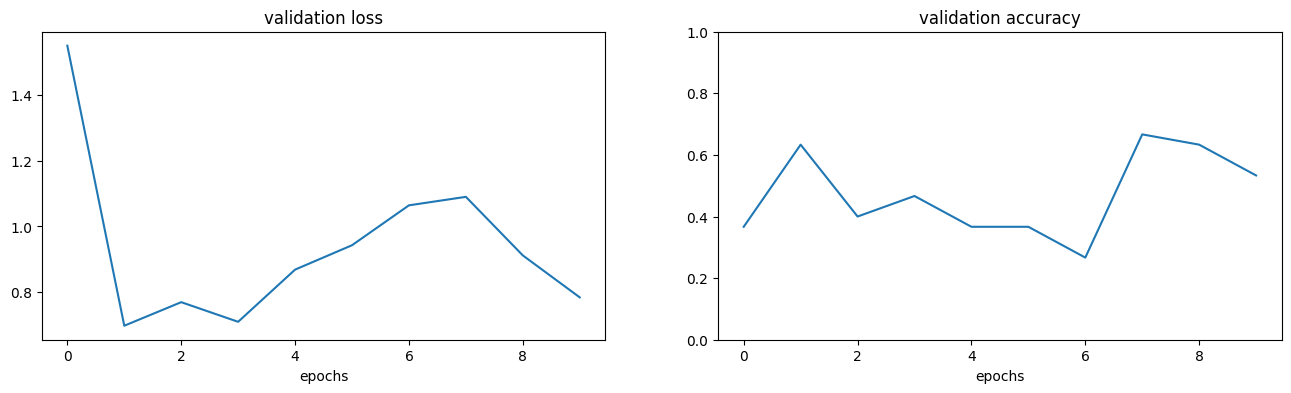

In [41]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
# Changed 'val_acc' to 'val_accuracy' to match the correct key in history.history
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que a perda de validação começa a realmente aumentar após cerca de 16 épocas, embora a precisão da validação permaneça aproximadamente entre 40% e 50%. Isso sugere que nosso modelo começa a sobreajustar por volta dessa época, e o melhor desempenho teria sido alcançado se tivéssemos parado cedo por volta dessa época. No entanto, nossa precisão provavelmente não teria sido acima de 50%, e provavelmente menor.

Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:

In [42]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.7741597294807434
Test accuracy: 0.6000000238418579


Transferência de aprendizagem começando com a rede existente
Agora podemos passar para a estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começar com uma rede maior e já treinada.

Para começar, carregaremos o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta for a primeira vez que você carrega o VGG16, você precisará esperar um pouco para que os pesos sejam baixados da web. Assim que a rede for carregada, podemos inspecionar novamente as camadas com o summary()método.

In [43]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Observe que o VGG16 é muito maior do que a rede que construímos anteriormente. Ele contém 13 camadas convolucionais e duas camadas totalmente conectadas no final, e tem mais de 138 milhões de parâmetros, cerca de 100 vezes mais parâmetros do que a rede que fizemos acima. Como nossa primeira rede, a maioria dos parâmetros é armazenada nas conexões que levam à primeira camada totalmente conectada.

O VGG16 foi criado para resolver o ImageNet e atinge uma taxa de erro top-5 de 8,8% , o que significa que 91,2% das amostras de teste foram classificadas corretamente dentro das 5 principais previsões para cada imagem. Sua precisão top-1 — equivalente à métrica de precisão que temos usado (que a previsão top está correta) — é de 73%. Isso é especialmente impressionante, pois não há apenas 97, mas 1000 classes, o que significa que palpites aleatórios nos dariam apenas 0,1% de precisão.

Para usar essa rede em nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 97 neurônios no caso do conjunto de dados 101_ObjectCategories.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG de sua camada de entrada até a segunda camada até a última, e então trabalhar com isso, em vez de modificar o objeto VGG diretamente. Então, tecnicamente, nunca "removemos" nada, apenas contornamos/ignoramos. Isso pode ser feito da seguinte maneira, usando a Modelclasse keras para inicializar um novo modelo cuja camada de entrada é a mesma que VGG, mas cuja camada de saída é nossa nova camada softmax, chamada new_classification_layer. Nota: embora pareça que estamos duplicando essa grande rede, internamente o Keras está na verdade apenas copiando todas as camadas por referência, e assim não precisamos nos preocupar em sobrecarregar a memória.

In [44]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Vamos treinar novamente essa rede, model_newno novo conjunto de dados e rótulos. Mas, primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto a nossa nova no final, com a expectativa de que os recursos que foram aprendidos no VGG ainda sejam razoavelmente relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente é melhor do que podemos treinar em nosso conjunto de dados limitado.

Ao definir o trainablesinalizador em cada camada como falso (exceto nossa nova camada de classificação), garantimos que todos os pesos e vieses nessas camadas permaneçam fixos e simplesmente treinamos os pesos em uma camada no final. Em alguns casos, é desejável não congelar todas as camadas de pré-classificação. Se seu conjunto de dados tiver amostras suficientes e não se assemelhar muito ao ImageNet, pode ser vantajoso ajustar algumas das camadas VGG junto com o novo classificador, ou possivelmente até mesmo todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais camadas treináveis.

No caso do CalTech-101, faremos apenas a extração de características, temendo que o ajuste fino demais com esse conjunto de dados possa causar overfit. Mas talvez estejamos errados? Um bom exercício seria experimentar ambos e comparar os resultados.

Então, vamos em frente e congelamos as camadas, e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda da nossa primeira rede, para fins de comparação justa. Então, executamos summarynovamente para observar a arquitetura da rede.


In [45]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,338,387 (512.46 MB)

 Trainable params: 77,843 (304.07 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Olhando para o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto que a última camada, anteriormente um softmax de 1000 neurônios, foi substituída por um novo softmax de 97 neurônios. Além disso, ainda temos aproximadamente 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis" porque congelamos as camadas em que estão contidos. Agora temos apenas 397.000 parâmetros treináveis, o que na verdade é apenas um quarto do número de parâmetros necessários para treinar o primeiro modelo.

Como antes, seguimos em frente e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, junto com o mesmo algoritmo de otimização. Também mantemos o controle do histórico dele conforme avançamos.

In [46]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 114s 28s/step - accuracy: 0.0190 - loss: 3.7394 - val_accuracy: 0.3667 - val_loss: 0.8120
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 136s 27s/step - accuracy: 0.4879 - loss: 0.7407 - val_accuracy: 0.4667 - val_loss: 0.7170
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 139s 26s/step - accuracy: 0.5295 - loss: 0.6772 - val_accuracy: 0.6333 - val_loss: 0.6676
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 149s 27s/step - accuracy: 0.4827 - loss: 0.7599 - val_accuracy: 0.6000 - val_loss: 0.6538
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 140s 27s/step - accuracy: 0.6521 - loss: 0.6373 - val_accuracy: 0.5333 - val_loss: 0.6734
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 138s 26s/step - accuracy: 0.6789 - loss: 0.6053 - val_accuracy: 0.5000 - val_loss: 0.6655
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 140s 26s/step - accuracy: 0.7379 - loss: 0.5779 - val_accuracy: 0.5000 - val_loss: 0.7424
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 152s 26s/step - accuracy: 0.5953 - loss: 0.6012 - val_accuracy: 0.6000 - val_loss:

Nossa precisão de validação fica próxima de 80% no final, o que representa uma melhoria de mais de 30% na rede original treinada do zero (o que significa que fazemos a previsão errada em 20% das amostras, em vez de 50%).

Vale a pena notar também que essa rede na verdade treina um pouco mais rápido que a rede original, apesar de ter mais de 100 vezes mais parâmetros! Isso ocorre porque congelar os pesos nega a necessidade de retropropagar por todas essas camadas, economizando tempo de execução.

Vamos traçar novamente a perda de validação e a precisão, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo aprendido por transferência em verde.

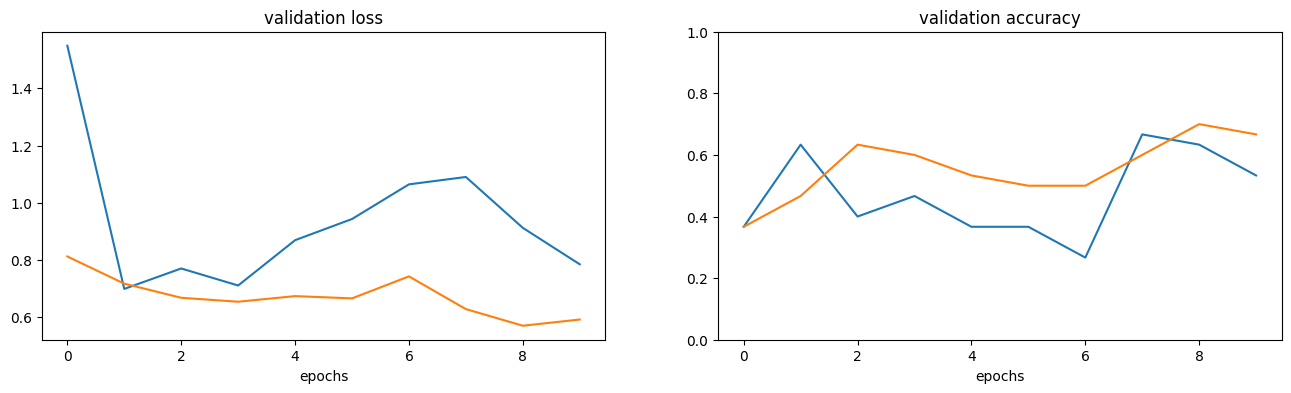

In [50]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
# Changed 'val_acc' to 'val_accuracy' to match the correct key in history.history
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que, enquanto o modelo original começou a sobreajustar em torno da época 16, o novo modelo continuou a diminuir lentamente sua perda ao longo do tempo e provavelmente teria melhorado sua precisão ligeiramente com mais iterações. O novo modelo chegou a aproximadamente 80% de precisão top-1 (no conjunto de validação) e continuou a melhorar lentamente ao longo de 100 épocas.

É possível que pudéssemos ter melhorado o modelo original com melhor regularização ou mais abandono, mas certamente não teríamos compensado a melhoria de >30% na precisão.

Novamente, fazemos uma validação final no conjunto de teste.

In [51]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.514999270439148
Test accuracy: 0.800000011920929


Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

In [83]:
img, x = get_image('DataSet_cat_dog/cachorros/cachorro_10.jpg')
probabilities = model_new.predict([x])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Melhorando os resultados
78,2% de precisão top-1 em 97 classes, distribuídas de forma aproximadamente uniforme, é uma conquista muito boa. Não é tão impressionante quanto o VGG16 original, que atingiu 73% de precisão top-1 em 1000 classes. No entanto, é muito melhor do que o que conseguimos atingir com nossa rede original, e há espaço para melhorias. Algumas técnicas que possivelmente poderiam ter melhorado nosso desempenho.

Uso de aumento de dados: aumento se refere ao uso de várias modificações dos dados de treinamento originais, na forma de distorções, rotações, redimensionamentos, alterações de iluminação, etc. para aumentar o tamanho do conjunto de treinamento e criar mais tolerância para tais distorções.
Usando um otimizador diferente, adicionando mais regularização/eliminação e outros hiperparâmetros.
Treinar por mais tempo (claro)
Um exemplo mais avançado de aprendizagem de transferência no Keras, envolvendo aumento para um pequeno conjunto de dados de 2 classes, pode ser encontrado no blog do Keras .